In [1]:
# This is about Modern Portfolio Theory 

In [2]:
import pandas as pd 
import numpy as np
import yfinance as yf 
import matplotlib.pyplot as plt

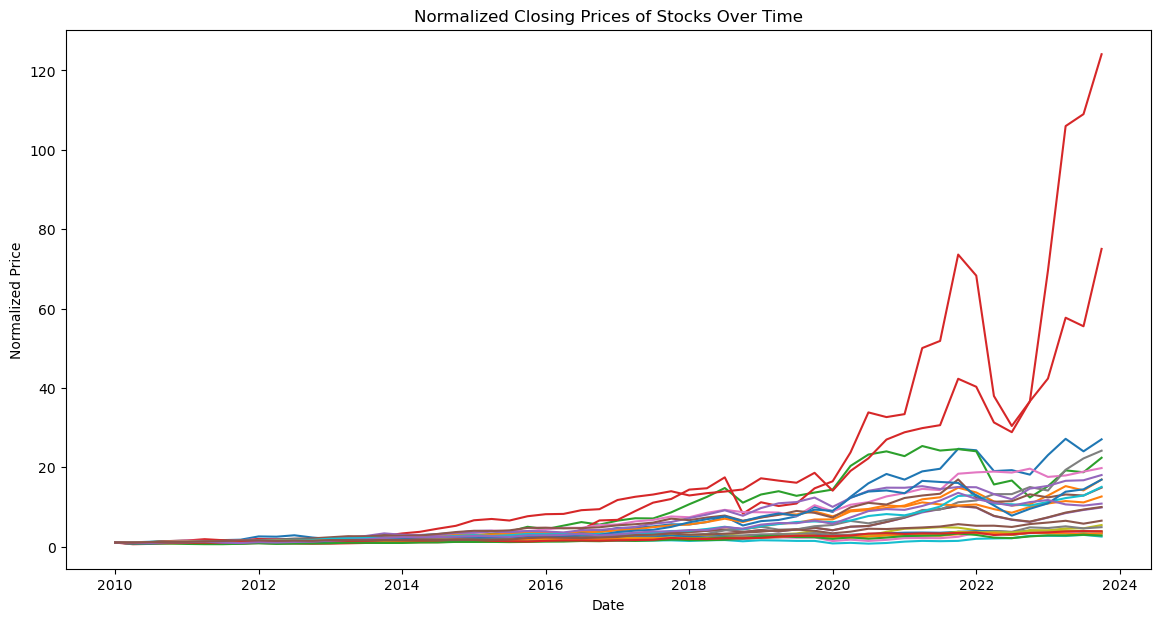

In [3]:
# Creating the stock objects

start_date = "2010-01-01"
end_date = "2024-01-01"
tickers_list = [
    "AAPL", "MSFT", "AMZN", "NVDA", "GOOGL", "GOOG", "UNH",
    "LLY", "JPM", "XOM", "JNJ", "V", "PG", "AVGO", "MA", "HD", "CVX",
    "MRK", "PEP", "COST", "ADBE", "KO", "CSCO", "WMT", "TMO", "MCD"]


# Adding it to a data frame
close_data = pd.DataFrame()

for ticker in tickers_list:
    ticker_data = yf.Ticker(ticker).history(start=start_date, end=end_date, interval="3mo")['Close']
    close_data[ticker] = ticker_data

# Plot the normalised close data over the years

normalised_data = close_data / close_data.iloc[0]

plt.figure(figsize=(14, 7))
for ticker in normalised_data.columns:
    plt.plot(normalised_data.index, normalised_data[ticker], label=ticker)

plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.title('Normalized Closing Prices of Stocks Over Time')
plt.show()


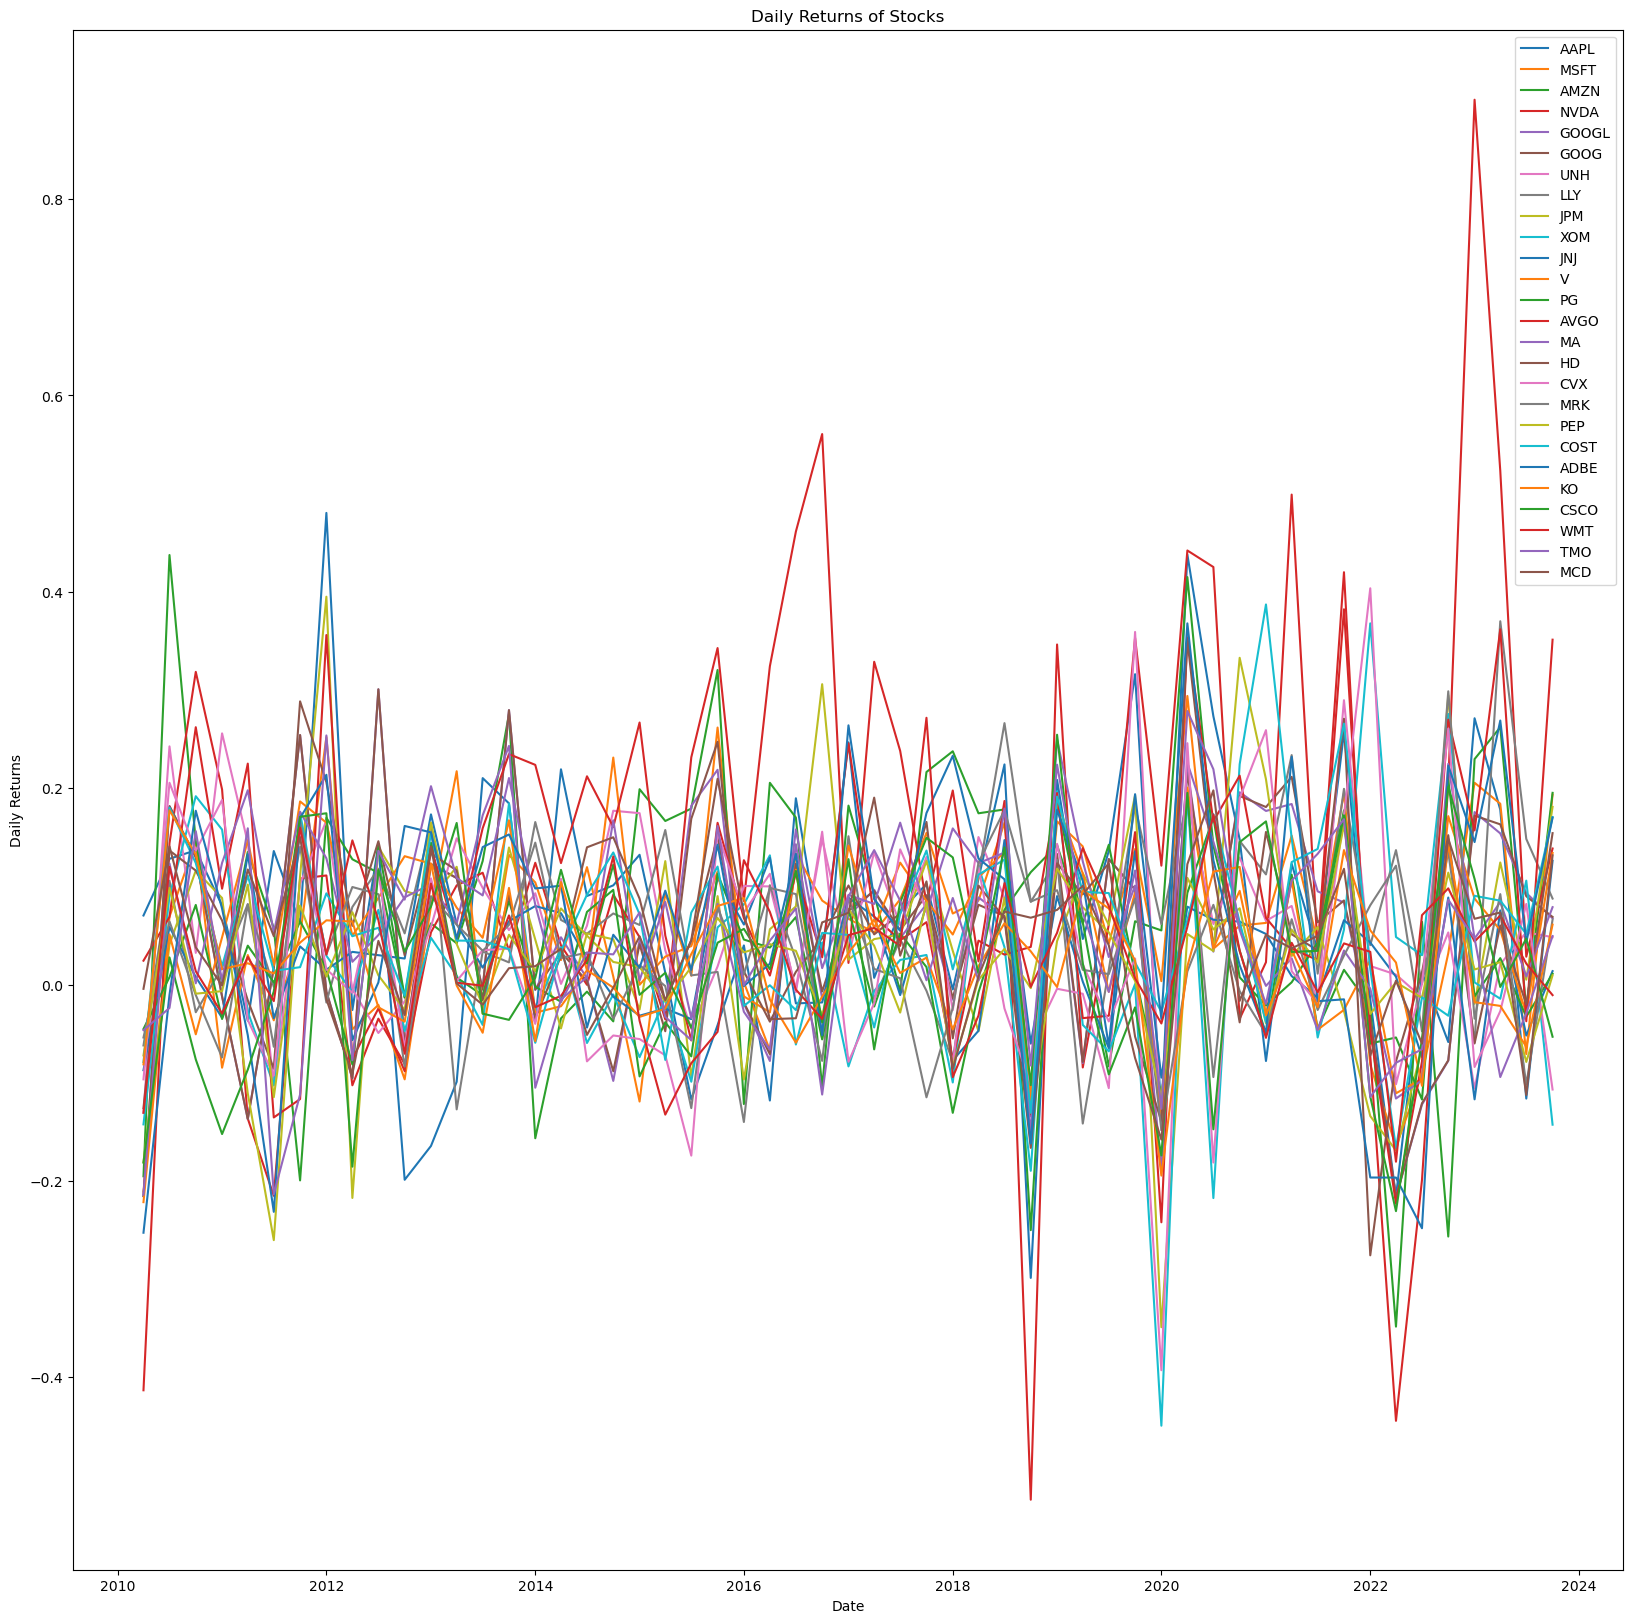

In [4]:
# Turn it into returns data and drop first term

returns_data = close_data.pct_change(fill_method=None).dropna()

# Plotting the returns

plt.figure(figsize=(20, 20))  # Set the figure size
for ticker in returns_data.columns:
    plt.plot(returns_data.index, returns_data[ticker], label=ticker)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.title('Daily Returns of Stocks')
plt.legend()
plt.show()


In [5]:
# Mean returns 
mean_returns = returns_data.mean().values

# variance covariance matrix - V Matrix
cov_matrix = returns_data.cov().values

In [6]:
# From MPT, we know the formula for the minimum variance weights are given by: 

# W_mv = ((V^-1)e)/(e'(V^-1)e)

num_assets = len(mean_returns)
ones = np.ones(num_assets) # this is the e vector of ones

# Inverse of the covariance matrix

if np.linalg.det(cov_matrix) != 0:
    cov_matrix_inverse = np.linalg.inv(cov_matrix)
else:
    print("Covariance matrix is singular and cannot be inverted.")

# Calculate the portfolio weightings 

w_mv = np.dot(cov_matrix_inverse, ones)/np.dot(ones.T, np.dot(cov_matrix_inverse, ones))

print(f"The minimum variance portfolio is given by: {w_mv}")

# Check the sum of the array of w_mv = 1 
total = 0 
for weight in w_mv:
    total += weight

print(f"These weights sum up to {round(total,1)}, as we would expect")


The minimum variance portfolio is given by: [ 0.0489501   0.05430411  0.09419678 -0.04512451  1.27266141 -1.3559431
  0.18274661  0.11462641  0.06821573  0.16190553 -0.02287023 -0.01414456
  0.22241127 -0.18552737 -0.12572302 -0.20044845 -0.13626444  0.08500171
  0.11560577  0.22819683  0.0599072   0.00687744  0.04598465  0.0703643
 -0.02257602  0.27666584]
These weights sum up to 1.0, as we would expect


In [7]:
# What's the expected return of this Minimum variance portfolio?

mvp_expected_return = np.dot(w_mv.T, mean_returns)
print(f"The expected return of the Minimum Variance Portfolio is: {mvp_expected_return}")

# What's the variance of the portfolio?
var = ((np.dot(ones.T, np.dot(cov_matrix_inverse, ones))))**-1
print(f"The variance of the Minimum Variance Portfolio is: {var}")

mvp_std = np.sqrt(var)

The expected return of the Minimum Variance Portfolio is: 0.027854862319789817
The variance of the Minimum Variance Portfolio is: 0.0018647428546317256


In [8]:
## Finding the Minimum Variance Frontier for a specific portfolio return.

In [9]:
# Solving the problem, we find:

set_target_return = 0.10

A = np.dot(mean_returns.T, np.dot(cov_matrix_inverse, mean_returns))
B = np.dot(ones.T, np.dot(cov_matrix_inverse, mean_returns))
C = np.dot(ones.T, np.dot(cov_matrix_inverse, ones))
D = (A*C) - (B**2)

# Solve for Lagrange multipliers (these are scalars)

lamba_1 = ((C*set_target_return) - B)/D
lamba_2 = (A - (B * set_target_return))/D


# Finding the weights of the portfolio to reach our target return - 

w = lamba_1*np.dot(cov_matrix_inverse, mean_returns) + lamba_2*np.dot(cov_matrix_inverse, ones)

print(f"The portfolio on the frontier that gives us a return of 10% is: {w}. \nThe sum of the weights = {round(np.dot(w.T, ones),1)}, matching the weights constraint.")

# Side - Checking we get the right return from this portfolio

R_p = np.dot(w.T, mean_returns)
if round(R_p, 2) == set_target_return:
    pass
else:
    print(f"The weighted portfolio doesn't equal the targeted return of: {set_target_return}")


# Print the variance 

port_variance_example = np.dot(w.T, np.dot(cov_matrix, w))
print(f"The variance of this portfolio is = {port_variance_example}")

The portfolio on the frontier that gives us a return of 10% is: [-0.15054254  0.22682672 -0.09600232  0.10463316  2.76403284 -2.82103996
  0.10235326  0.71869995 -0.08876254 -0.16729752 -0.44286761  0.28815576
 -0.57574765  0.17926196  0.15085034  0.10258135  0.18739829  0.13862144
 -0.92696412  0.19903204 -0.32508139  0.19866168 -0.20229855  0.49214513
  0.477805    0.46554529]. 
The sum of the weights = 1.0, matching the weights constraint.
The variance of this portfolio is = 0.007475022210636297


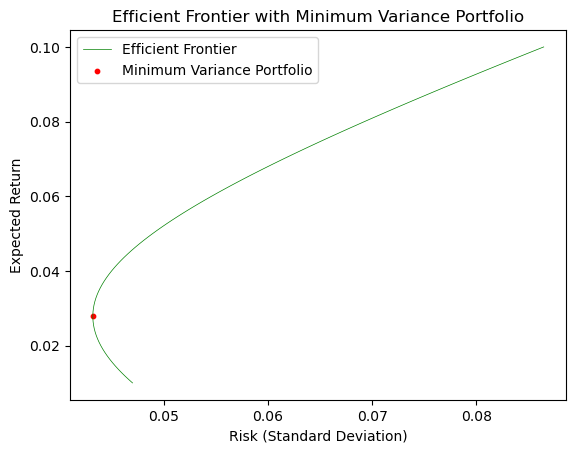

In [10]:
# Plotting the whole mean-variance frontier - standard deviation on x-axis and portfolio return on the y-axis.

# The MVF shows us the set of portfolios that offer the highest expected return for a given level of risk. 
# So now we need to generate a range of returns to form the corresponding portfolios for the frontier.

# Firstly, let's create an equally spaced array of returns 

full_returns = np.linspace(0.01, 0.10, 100)

# Create an empty list for the std of each portfolio

full_port_std = []

for Rp in full_returns:
    lambda_1 = (C * Rp - B) / D
    lambda_2 = (A - B * Rp) / D
    w = lambda_1 * np.dot(cov_matrix_inverse, mean_returns) + lambda_2 * np.dot(cov_matrix_inverse, ones) # Weightings of this specifc portfolio
    portfolio_variance = np.dot(w.T, np.dot(cov_matrix, w))
    full_port_std.append(np.sqrt(portfolio_variance))  # Standard deviation

# Plot the efficient frontier
plt.plot(full_port_std, full_returns, 'g-', linewidth=0.5, label='Efficient Frontier')

# Plot the minimum variance portfolio point on top of the efficient frontier
plt.scatter(mvp_std, mvp_expected_return, color='red', marker='o', s=10, label='Minimum Variance Portfolio')

# Labels
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Minimum Variance Portfolio')
plt.legend()
plt.show()


In [11]:
##############################################################################################################################################

In [12]:
##############################################################################################################################################